In [1]:
#!/usr/bin/env python

# Scaling_Changes.ipynb

In [2]:
'''File name: Scaling_Changes.ipynb
    Author: Andreas Prein
    E-mail: prein@ucar.edu
    Date created: 26.05.2022
    Date last modified: 26.05.2022

    ############################################################## 
    Purpos:

    - Rean in hourly precipitation data from CONUS404 
    - Read in hourly dewpoint temperature data from CONUS404
    - Calculate scaling diagrams by year and region 

'''

'File name: Scaling_Changes.ipynb\n    Author: Andreas Prein\n    E-mail: prein@ucar.edu\n    Date created: 26.05.2022\n    Date last modified: 26.05.2022\n\n    ############################################################## \n    Purpos:\n\n    - Rean in hourly precipitation data from CONUS404 \n    - Read in hourly dewpoint temperature data from CONUS404\n    - Calculate scaling diagrams by year and region \n\n'

In [3]:
import numpy as np
from scipy import stats
import matplotlib.pyplot as plt
from netCDF4 import Dataset
import glob
import os
from pdb import set_trace as stop
from scipy.ndimage.filters import gaussian_filter
from scipy.ndimage import median_filter
from scipy.ndimage import label
from matplotlib import cm
from scipy import ndimage
import random
import scipy
import pickle
import datetime
import pandas as pd
import subprocess
from calendar import monthrange
import pandas as pd
import datetime
import sys 
import shapefile as shp
import matplotlib.path as mplPath
from scipy.stats import norm
import matplotlib.gridspec as gridspec
# from mpl_toolkits.basemap import Basemap, cm
from matplotlib.colors import LinearSegmentedColormap
import matplotlib.gridspec as gridspec
from pylab import *
import string
from matplotlib.patches import Polygon
from matplotlib.collections import PatchCollection
import shapefile
from calendar import monthrange
from tqdm import tqdm
import xarray as xr

import cartopy.crs as ccrs
import matplotlib.pyplot as plt
import shapely.geometry as sgeom
from matplotlib.colors import LogNorm
from cartopy.feature import NaturalEarthFeature
import cartopy.feature as cf

from wrf import (to_np, getvar, smooth2d, get_cartopy, cartopy_xlim,
                 cartopy_ylim, latlon_coords)

def read_shapefile(sf):
    """
    Read a shapefile into a Pandas dataframe with a 'coords' 
    column holding the geometry information. This uses the pyshp
    package
    """
    fields = [x[0] for x in sf.fields][1:]
    records = sf.records()
    shps = [s.points for s in sf.shapes()]
    df = pd.DataFrame(columns=fields, data=records)
    df = df.assign(coords=shps)
    return df

#### speed up interpolation
import scipy.interpolate as spint
import scipy.spatial.qhull as qhull
import numpy as np

def interp_weights(xy, uv,d=2):
    tri = qhull.Delaunay(xy)
    simplex = tri.find_simplex(uv)
    vertices = np.take(tri.simplices, simplex, axis=0)
    temp = np.take(tri.transform, simplex, axis=0)
    delta = uv - temp[:, d]
    bary = np.einsum('njk,nk->nj', temp[:, :d, :], delta)
    return vertices, np.hstack((bary, 1 - bary.sum(axis=1, keepdims=True)))

def interpolate(values, vtx, wts):
    return np.einsum('nj,nj->n', np.take(values, vtx), wts)

def deiscretice_timeseries(DATA,
                          bucked_size):
#     Discrete_timeseries = np.copy(DATA); Discrete_timeseries[:] = np.nan
#     for tt in range(len(DATA)):
#         if ~np.isnan(DATA[tt]) == True:   
#             INT, REST = divmod(DATA[tt], bucked_size)
#             Discrete_timeseries[tt] = INT * bucked_size
#             if tt != len(DATA)-1:
#                 DATA[tt+1] = DATA[tt+1]+REST
#     return Discrete_timeseries

    if len(DATA.shape) == 1:
        # make data 2D
        DATA = DATA[:,None]
    Discrete_timeseries = np.copy(DATA); Discrete_timeseries[:] = np.nan
    for tt in tqdm(range(DATA.shape[0])):
        INT, REST = np.apply_along_axis(np.divmod, 0, DATA[tt,:], bucked_size)
        FIN = ~np.isnan(INT)
        Discrete_timeseries[tt,:] = INT * bucked_size
        if tt != len(DATA)-1:
            DATA[tt+1,FIN] = DATA[tt+1,FIN]+REST[FIN]
    return Discrete_timeseries

In [4]:
# ================================
# BUKOFSKY REGION
# Add the subregions
import geopandas as gpd
from tqdm import tqdm

REGIONS = [ 'Appalachia.shp',
            'CPlains.shp',
            'DeepSouth.shp',
            'GreatBasin.shp',
            'GreatLakes.shp',
            'Mezquital.shp',
            'MidAtlantic.shp',
            'NorthAtlantic.shp',
            'NPlains.shp',
            'NRockies.shp',
            'PacificNW.shp',
            'PacificSW.shp',
            'Prairie.shp',
            'Southeast.shp',
            'Southwest.shp',
            'SPlains.shp',
            'SRockies.shp']

REGIONS_names = [ 'Appalachia',
            'Central Plains',
            'Deep South',
            'Great Basin',
            'Great Lakes',
            'Mezquital',
            'Mid-Atlantic',
            'North-Atlantic',
            'Northern Plains',
            'Northern Rockies',
            'Pacific Northwest',
            'Pacific Southwest',
            'Prairie',
            'Southeast',
            'Southwest',
            'Southern Plains',
            'Southern Rockies']

In [5]:
##############################################################
#                READ CONUS404 CONSTANT FIELDS
sLon='XLONG'
sLat='XLAT'
sOro='HGT'
sLSM='LANDMASK'
sPlotDir = ''
GEO_EM_D1 = '/glade/campaign/ncar/USGS_Water/CONUS404/wrfconstants_d01_1979-10-01_00:00:00.nc4'

ncid=Dataset(GEO_EM_D1, mode='r') # open the netcdf
Lon=np.squeeze(ncid.variables[sLon][:])
Lat=np.squeeze(ncid.variables[sLat][:])
Height4=np.squeeze(ncid.variables[sOro][:])
LSM=np.squeeze(ncid.variables[sLSM][:])
ncid.close()

In [6]:
DataFolder = '/glade/campaign/mmm/c3we/prein/CONUS404/data/MonthlyData/'
SaveFolder = '/glade/campaign/mmm/c3we/prein/CONUS404/data/CONUS404_processed_data/'

StartDay = datetime.datetime(1980, 1, 1, 0)
StopDay = datetime.datetime(2019, 12, 31, 23)
TimeHH = pd.date_range(StartDay, end=StopDay, freq='1h')
TimeMM = pd.date_range(StartDay, end=StopDay, freq='M')
Years = np.unique(TimeMM.year)

Seasons = ['annual','DJF','MAM','JJA','SON']
rgiSeasons = [range(1,13,1),
                 [1,2,12],
                 [3,4,5],
                 [6,7,8],
                 [9,10,11]]

dry_threshold = 0.1 # mm/h
lag_hours = 2 # hours before the pr event that dT is taken

In [7]:
MaskFile = '../CONUS404_pr-changes/Burkofski_Regions_CONUS404.npz'
if os.path.exists(MaskFile) == False:
    rgiStatsInBasins = []
    MaskStations = np.zeros((Lon.shape[0],Lon.shape[1])); MaskStations[:] = np.nan
    rgrGridCells=[(Lon.flatten()[ii],Lat.flatten()[ii]) for ii in range(len(Lon.flatten()))]
    for re in tqdm(range(len(REGIONS))):
        data = gpd.read_file('/glade/u/home/prein/papers/2021_Hist-Ext-PR-Changes/shapefiles/Bukovski-Regions/'+REGIONS[re])
        Coordinates = data['geometry']
        for sf in range(len(data)):
            TEST = np.array(Coordinates[sf].exterior.coords.xy)
            ctr=TEST.T
            grPRregion=mplPath.Path(ctr)
            TMP=np.array(grPRregion.contains_points(rgrGridCells))
        TMP = np.reshape(TMP, (Lon.shape[0], Lon.shape[1]))
        MaskStations[TMP==1] = re+1
    #     MaskStations = np.append(MaskStations,[re+1]*len(iStationSelect))
    MaskStations = MaskStations.astype('int')
    
    np.savez(MaskFile,
            MaskStations = MaskStations,
            Lon = Lon,
            Lat = Lat)
else:
    DATA = np.load(MaskFile)
    MaskStations = DATA['MaskStations']
    Lon = DATA['Lon']
    Lat = DATA['Lat']
MaskStations[MaskStations < 0] = 0

Region_indices = ndimage.find_objects(MaskStations)
# Region_indices = ndimage.find_objects(MaskStations)

### Read CONUS404 data and calculate scalling curves year by year
This reads data that is preprocessed in - 
papers/2021_Hist-Ext-PR-Changes/programs/Scaling_Changes/Scaling_Changes.py

In [8]:
bins_dT = np.arange(-30,35,0.1)
pr_perc = (99, 99.5, 99.9, 99.99)
prec_yy_all = np.array(np.zeros((len(Years), len(bins_dT), len(pr_perc), len(REGIONS_names)))); prec_yy_all[:] = np.nan

# Bins according to DT
NN = 100
bins = np.array([0]+ [np.exp(np.log(0.005) + (ii* ((np.log(160)-np.log(0.005))**2/(NN)) )**0.5 ) for ii in range(NN)])
bins_cent = (bins[1:]+bins[:-1])/2
bins_width = bins[1:] - bins[:-1]
dT_perc = (99.9, 99, 50, 1, 0.1)
dT_yy_all = np.zeros((len(Years), len(bins_cent), len(dT_perc), len(REGIONS_names))); dT_yy_all[:] = np.nan

for yy in tqdm(range(len(Years))):
    YYYY = Years[yy]
    file_act = SaveFolder+'pr_vs_dT/'+str(YYYY)+'_pr-vs-dT_Bukovsky-regions.npz'
    if os.path.isfile(file_act):
        DATA = np.load(file_act)
        prec_yy_all[yy,:,:,:] = DATA['binned_pr']
        dT_yy_all[yy,:,:,:] = DATA['binned_dT']

        


100%|██████████| 40/40 [00:01<00:00, 21.09it/s]


### Calculate linear trends in bins

In [9]:
perc_pr = 99.9
perc_dT = 1
perc_dT_high = 99.9

trend_pr = np.zeros((len(bins_dT),5, len(REGIONS_names))); trend_pr[:] = np.nan
for re in range(len(REGIONS_names)):
    for bi in range(len(bins_dT)):
        if np.sum(~np.isnan(prec_yy_all[:, bi, pr_perc.index(perc_pr), re])) >= len(Years)*0.8:
            trend_pr[bi,:,re] = stats.linregress(Years, prec_yy_all[:, bi, pr_perc.index(perc_pr), re])

trend_dT = np.zeros((len(bins_cent),5, len(REGIONS_names))); trend_dT[:] = np.nan
for re in range(len(REGIONS_names)):
    for bi in range(len(bins_cent)):
        if np.sum(~np.isnan(dT_yy_all[:, bi, dT_perc.index(perc_dT), re])) >= len(Years)*0.8:
            trend_dT[bi,:,re] = stats.linregress(Years, dT_yy_all[:, bi, dT_perc.index(perc_dT), re])
            
trend_dT_high = np.zeros((len(bins_cent),5, len(REGIONS_names))); trend_dT_high[:] = np.nan
for re in range(len(REGIONS_names)):
    for bi in range(len(bins_cent)):
        if np.sum(~np.isnan(dT_yy_all[:, bi, dT_perc.index(perc_dT_high), re])) >= len(Years)*0.8:
            trend_dT_high[bi,:,re] = stats.linregress(Years, dT_yy_all[:, bi, dT_perc.index(perc_dT_high), re])


/glade/u/apps/dav/opt/python/3.7.9/gnu/9.1.0/pkg-library/20201220/lib/python3.7/site-packages/scipy/stats/_distn_infrastructure.py:1932: RuntimeWarning: invalid value encountered in less_equal
  cond2 = cond0 & (x <= _a)


In [10]:
# interpolate scaling curves to dT and calulate trends in dT for pr bins
from scipy.interpolate import interp1d
pr_bins_int = np.arange(0,120,2)

dT_yy_interp = np.zeros((len(Years), len(pr_bins_int), len(REGIONS_names))); dT_yy_interp[:] = np.nan
for re in range(len(REGIONS_names)):
    for yy in range(len(Years)):
        for bi in range(len(bins_cent)):
            YY = prec_yy_all[yy,:,pr_perc.index(perc_pr),re]
            XX = bins_dT
            f = interp1d(YY,XX, assume_sorted = True)
            try:
                dT_yy_interp[yy,bi,re] = f(pr_bins_int[bi])
            except:
                continue


/glade/u/apps/dav/opt/python/3.7.9/gnu/9.1.0/pkg-library/20201220/lib/python3.7/site-packages/scipy/interpolate/interpolate.py:683: RuntimeWarning: invalid value encountered in less
  below_bounds = x_new < self.x[0]
/glade/u/apps/dav/opt/python/3.7.9/gnu/9.1.0/pkg-library/20201220/lib/python3.7/site-packages/scipy/interpolate/interpolate.py:684: RuntimeWarning: invalid value encountered in greater
  above_bounds = x_new > self.x[-1]


In [11]:
# Calculated trends in interpolated dT values
dT_yy_trend = np.zeros((len(pr_bins_int),5, len(REGIONS_names))); dT_yy_trend[:] = np.nan
for re in range(len(REGIONS_names)):
    for bi in range(len(pr_bins_int)):
        if np.sum(~np.isnan(dT_yy_interp[:, bi, re])) >= len(Years)*0.8:
            dT_yy_trend[bi,:,re] = stats.linregress(Years, dT_yy_interp[:, bi, re])

        Plot map to: PR-vs-dT_scaling-rate-changes.pdf


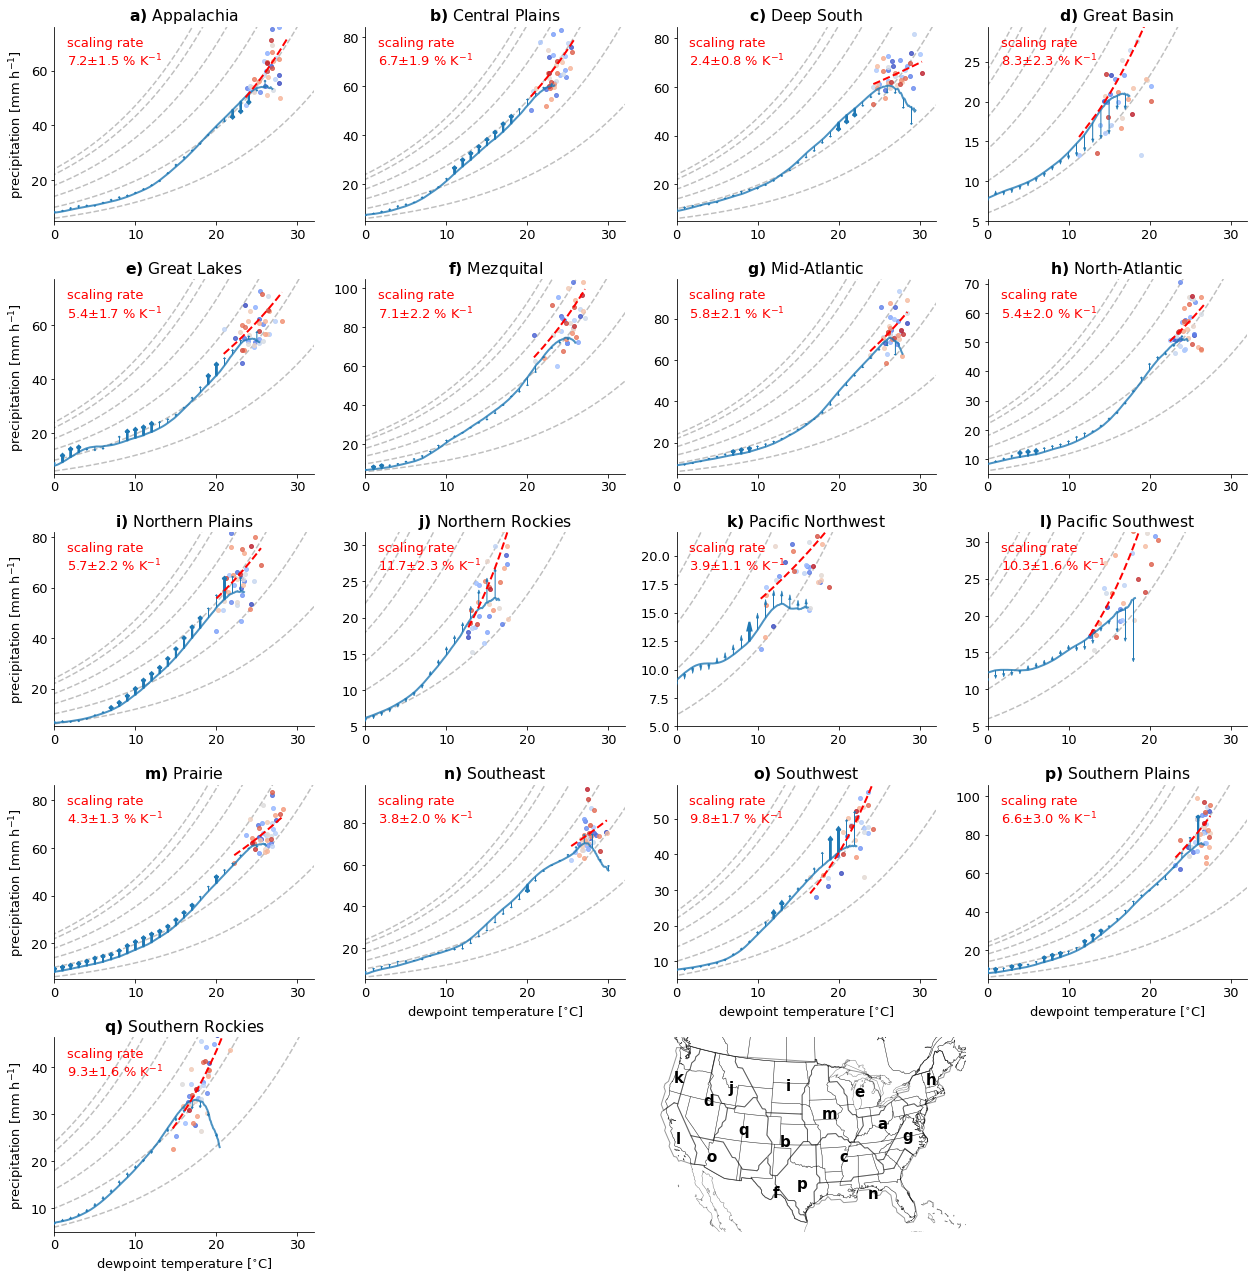

In [12]:
ncfile = Dataset(GEO_EM_D1)
HGT_M = getvar(ncfile, "HGT")
cart_proj = get_cartopy(HGT_M)
ncid.close()


from scipy.optimize import curve_fit
def func(x, li, sc):
    return li * (1+sc)**x

fig = plt.figure(figsize=(18,18))
rgsLableABC=list(string.ascii_lowercase)
plt.rcParams.update({'font.size': 13})
gs1 = gridspec.GridSpec(5,4)
gs1.update(left=0.05, right=0.97,
           bottom=0.05, top=0.98,
           wspace=0.20, hspace=0.30)

XX = [0,1,2,3,0,1,2,3,0,1,2,3,0,1,2,3,0,1,2,3]
YY = [0,0,0,0,1,1,1,1,2,2,2,2,3,3,3,3,4,4,4,4]
for re in range(len(REGIONS_names)):
    ax = plt.subplot(gs1[YY[re],XX[re]])

    pr_scaling_mean = np.mean(prec_yy_all[:,:,pr_perc.index(perc_pr),re], axis=0)
    plt.plot(bins_dT, pr_scaling_mean, c='#1f78b4', alpha=0.8, lw=2, zorder = 10)
    # add arrows for significant changes
    for bi in range(len(bins_dT))[::10]:
        dy = trend_pr[bi,0,re]*40
        if trend_pr[bi,3,re] <= 0.1:
            plt.arrow(x=bins_dT[bi], y=pr_scaling_mean[bi], dx=0, dy=dy, linewidth=2, facecolor='#1f78b4', edgecolor='#1f78b4', zorder = 10, head_width = 0.5) 
        else:
            plt.arrow(x=bins_dT[bi], y=pr_scaling_mean[bi], dx=0, dy=dy, linewidth=0.5, facecolor='#1f78b4', edgecolor='#1f78b4', zorder = 10, head_width = 0.3) 

#     # plot interpolated dT trends
#     trend_dT_high_mean = np.nanmean(dT_yy_interp[:,:,re], axis=0)
#     # plt.plot(trend_dT_high_mean, pr_bins_int, c='g', alpha=1)
#     for bi in range(len(pr_bins_int))[::2]:
#         dy = dT_yy_trend[bi,0,re]* 40
#         if dT_yy_trend[bi,3,re] <= 0.1:
#             plt.arrow(x=trend_dT_high_mean[bi], y=pr_bins_int[bi], dx=dy, dy=0, width=.3, facecolor='#1f78b4', edgecolor='none') 
#         else:
#             plt.arrow(x=trend_dT_high_mean[bi], y=pr_bins_int[bi], dx=dy, dy=0, width=.15, facecolor='#1f78b4', edgecolor='none') 


#     dT_scaling_mean = np.mean(dT_yy_all[:, :, dT_perc.index(perc_dT),re], axis=0)
#     plt.plot(dT_scaling_mean, bins_cent, c='r', alpha=0.5)
#     # add arrows for significant changes
#     for bi in range(len(bins_cent))[::3]:
#         dx = trend_dT[bi,0,re]*40
#         if trend_dT[bi,3,re] <= 0.1:
#             plt.arrow(x=dT_scaling_mean[bi], y=bins_cent[bi], dx=dx, dy=0, linewidth=2, facecolor='r', edgecolor='r', head_width = 0.7, head_length=0.3) 
#         else:
#             plt.arrow(x=dT_scaling_mean[bi], y=bins_cent[bi], dx=dx, dy=0, linewidth=0.5, facecolor='r', edgecolor='r', head_width = 0.3, head_length=0.3) 

#     dT_scaling_mean = np.mean(dT_yy_all[:, :, dT_perc.index(perc_dT_high),re], axis=0)
#     plt.plot(dT_scaling_mean, bins_cent, c='r', alpha=0.5)
#     # add arrows for significant changes
#     for bi in range(len(bins_cent))[::3]:
#         dx = trend_dT_high[bi,0,re]*40
#         if trend_dT_high[bi,3,re] <= 0.1:
#             plt.arrow(x=dT_scaling_mean[bi], y=bins_cent[bi], dx=dx, dy=0, linewidth=2, facecolor='r', edgecolor='r', head_width = 0.7, head_length=0.3) 
#         else:
#             plt.arrow(x=dT_scaling_mean[bi], y=bins_cent[bi], dx=dx, dy=0, linewidth=0.5, facecolor='r', edgecolor='r', head_width = 0.3, head_length=0.3) 


    # plot location of peak value
    cmap = matplotlib.cm.get_cmap('coolwarm')

    peak_x = np.zeros((prec_yy_all.shape[0])); peak_x[:] = np.nan
    peak_y = np.copy(peak_x)
    for yy in range(prec_yy_all.shape[0]):
        iMax = np.nanargmax(prec_yy_all[yy,:,pr_perc.index(perc_pr),re])
        rgba = cmap(yy/prec_yy_all.shape[0])
        peak_x[yy] = bins_dT[iMax]
        peak_y[yy] = prec_yy_all[yy,iMax,pr_perc.index(perc_pr),re]
        plt.plot(bins_dT[iMax],prec_yy_all[yy,iMax,pr_perc.index(perc_pr),re], color=rgba, marker = 'o', markersize=4, alpha = 0.8)
    
    # get scaling rate                 
    popt, pcov = curve_fit(func, peak_x, peak_y)
    y_CC_rate = np.array([popt[0]*(1 + popt[1])**bi for bi in np.sort(peak_x)])
    plt.plot(np.sort(peak_x),y_CC_rate, c='r', ls = '--', alpha=1, zorder = 10, lw=2)
    perr = np.sqrt(np.diag(pcov))
    plt.text(0.05,0.8,'scaling rate\n'+str(np.round(popt[1]*100, 1))+\
             '$\pm$'+str(np.round(perr[1]*100,1))+' % K$^{-1}$', transform=ax.transAxes, c='r')

    for li in [6,10,14,18,22,24]:
        y_CC_rate = np.array([li*(1 + 0.07)**bi for bi in bins_dT])
        plt.plot(bins_dT,y_CC_rate, c='k', ls = '--', alpha=0.25, zorder = 1)

    plt.title(r"$\bf{" + rgsLableABC[re] + ")}$ "+REGIONS_names[re])
    plt.ylim((5,np.nanmax(pr_scaling_mean)*1.4))
    plt.xlim((0,32))
    
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    if XX[re] == 0:
        ax.set_ylabel('precipitation [mm h$^{-1}$]')
    if (YY[re] == 4) | ((YY[re] == 3) & (XX[re] > 0)):
        ax.set_xlabel('dewpoint temperature [$^{\circ}$C]')
    
    
# -----------------------
# plot an overview map showing the region locaations
ax = plt.subplot(gs1[4,1:4], projection=cart_proj)
import geopandas as gpd
ncfile = Dataset('/glade/u/home/prein/projects/2020_CONUS404/programs/plots/Domain/geo_em.d01.nc')
HGT_M = getvar(ncfile, "HGT_M")
cart_proj = get_cartopy(HGT_M)
ncid.close()
for re in range(len(REGIONS)):
    data = gpd.read_file('/glade/u/home/prein/papers/2021_Hist-Ext-PR-Changes/shapefiles/Bukovski-Regions/'+REGIONS[re])
    Coordinates = data['geometry']
    for sf in range(len(data)):
        TEST = np.array(Coordinates[sf].exterior.coords.xy)
        TEST=TEST.T
        plt.plot(TEST[:,0],TEST[:,1], lw=1, c='k', transform=ccrs.PlateCarree(), alpha=0.4)
        # label the region
        XX = np.mean(TEST[:,0])
        YY = np.mean(TEST[:,1])
        plt.text(XX,YY, r"$\bf{" + rgsLableABC[re] + "}$", transform=ccrs.PlateCarree(), color='k', fontsize=15, ha='center',va='center')
        
plt.axis('off')
ax.coastlines(lw=0.5, alpha=0.5)
ax.add_feature(cf.BORDERS, lw=0.5, alpha=0.5)
ax.add_feature(cf.STATES, lw=0.5, alpha=0.5)
    
# ax.set_yscale('log')

sPlotFile=sPlotDir
sPlotName= 'PR-vs-dT_scaling-rate-changes.pdf'
if os.path.isdir(sPlotFile) != 1:
    subprocess.call(["mkdir","-p",sPlotFile])
print( '        Plot map to: '+sPlotFile+sPlotName)
fig.savefig(sPlotFile+sPlotName) #, dpi=700)

### Plot changes in fractional distribution of precipitation

In [13]:
DATA = np.load(SaveFolder+'Fractional_Contribution_changes.npz')
pr_frac_contributions = DATA['pr_frac_contributions']
REGIONS_names = DATA['REGIONS_names']
bins = DATA['bins']
bootstratp_nr = DATA['bootstratp_nr']
SampleSize = DATA['SampleSize']

### Plot for paper that shows results for key regions

In [103]:
se=0
key_regions = [7,13,4,14]

### Read example data to visualize scatter plot

In [15]:
YYYY = 2000
# rgiHours = (TimeHH.year == YYYY)
# timeHH_yy = TimeHH[rgiHours]
# prec_yy = np.array(np.zeros((len(timeHH_yy), Lon.shape[0], Lon.shape[1])), dtype=np.float32); prec_yy[:] = np.nan
# dT_yy = np.copy(prec_yy)
# for mm in tqdm(range(12)):
#     MM = mm+1
#     time_mm_in_yy = timeHH_yy.month == MM

#     # read precipitation
#     File_act = DataFolder + 'PREC_ACC_NC_'+str(YYYY)+str(MM).zfill(2)+'_CONUS404.nc'
#     ncid=Dataset(File_act, mode='r') # open the netcdf
#     prec_yy[time_mm_in_yy,:,:] = np.array(np.squeeze(ncid.variables['PREC_ACC_NC'][:]), dtype=np.float32)
#     ncid.close()

#     # read 2m dewpoint temperature
#     File_act = DataFolder + 'TD2_'+str(YYYY)+str(MM).zfill(2)+'_CONUS404.nc'
#     ncid=Dataset(File_act, mode='r') # open the netcdf
#     dT_yy[time_mm_in_yy,:,:] = np.array(np.squeeze(ncid.variables['TD2'][:]), dtype=np.float32)-273.15
#     ncid.close()

# for re in [key_regions[0]]:
#     prec_yy_re = prec_yy[:,Region_indices[re][0].start:Region_indices[re][0].stop, 
#                       Region_indices[re][1].start:Region_indices[re][1].stop][:,MaskStations[Region_indices[re]] == re+1]
#     dT_yy_re = dT_yy[:,Region_indices[re][0].start:Region_indices[re][0].stop, 
#               Region_indices[re][1].start:Region_indices[re][1].stop][:,MaskStations[Region_indices[re]] == re+1]

#     wet_hours = np.argwhere(prec_yy_re >= dry_threshold)
#     dT_sampling_time = np.copy(wet_hours)
#     dT_sampling_time[:,0] = wet_hours[:,0] - lag_hours
#     dT_sampling_time[dT_sampling_time[:,0] < 0, 0] = 0
#     prec_yy_re_wet = prec_yy_re[wet_hours[:,0], wet_hours[:,1]]
#     dT_yy_re_wet = dT_yy_re[dT_sampling_time[:,0], dT_sampling_time[:,1]]
    
# np.savez(SaveFolder+'Example_dT-PR_data-scatterplot_'+str(YYYY)+'_'+REGIONS[key_regions[re]]+'.npz',
#         prec_yy_re_wet = prec_yy_re_wet,
#         dT_yy_re_wet = dT_yy_re_wet)

DATA = np.load(SaveFolder+'Example_dT-PR_data-scatterplot_'+str(YYYY)+'_'+REGIONS[key_regions[-1]]+'.npz')
prec_yy_re_wet = DATA['prec_yy_re_wet']
dT_yy_re_wet = DATA['dT_yy_re_wet']

work on NorthAtlantic.shp
work on Southeast.shp
work on GreatLakes.shp
work on Southwest.shp


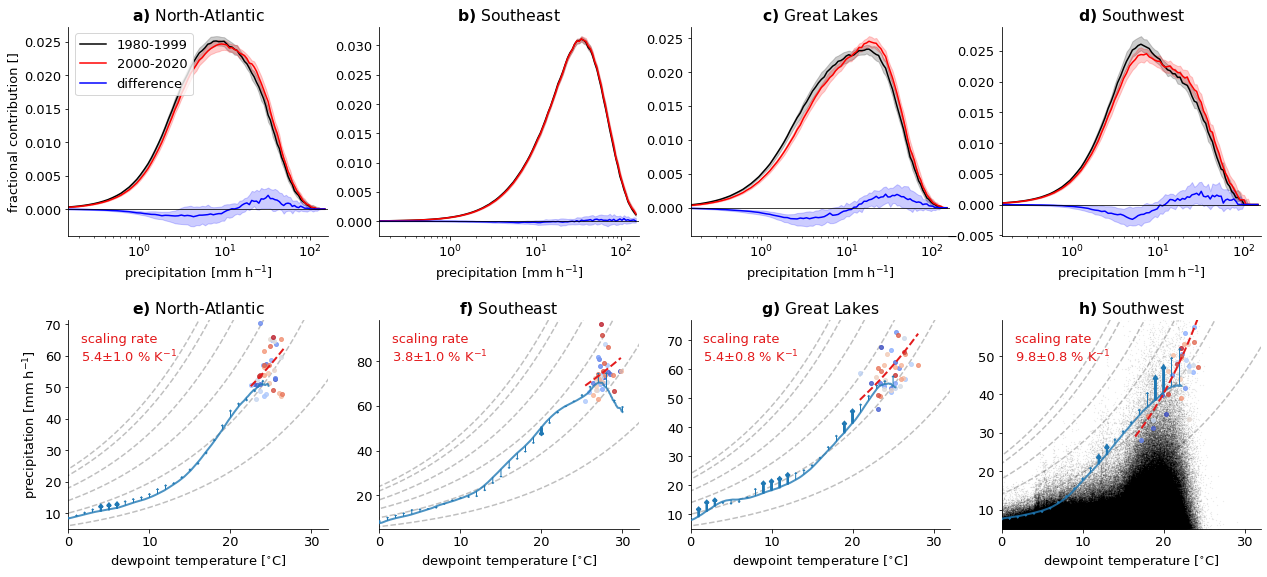

In [16]:
fig = plt.figure(figsize=(18,7.5))
rgsLableABC=list(string.ascii_lowercase)
plt.rcParams.update({'font.size': 13})
gs1 = gridspec.GridSpec(2,4)
gs1.update(left=0.05, right=0.97,
           bottom=0.05, top=0.98,
           wspace=0.20, hspace=0.40)

for re in range(len(key_regions)):
    ax = plt.subplot(gs1[0,re])
    
    print('work on '+REGIONS[key_regions[re]])
    Contribution = np.median(pr_frac_contributions[:,0,:,key_regions[re]]*bins_width[:,None]/np.sum(pr_frac_contributions[:,0,:,key_regions[re]]*bins_width[:,None], axis=0), axis=1)
    cont_spread = np.percentile(pr_frac_contributions[:,0,:,key_regions[re]]*bins_width[:,None]/np.sum(pr_frac_contributions[:,0,:,key_regions[re]]*bins_width[:,None], axis=0), (25,75),  axis=1)
#     cont_spread = cont_spread*bins_width[None,:]/np.sum(cont_spread*bins_width[None,:], axis=1)[:,None]
    plt.plot(bins_cent, Contribution, c='k', label = '1980-1999')
    plt.fill_between(bins_cent, cont_spread[0,:], y2=cont_spread[1,:], color='k', alpha=0.2)

    Contribution1 = np.median(pr_frac_contributions[:,1,:,key_regions[re]]*bins_width[:,None]/np.sum(pr_frac_contributions[:,1,:,key_regions[re]]*bins_width[:,None], axis=0), axis=1)
    cont_spread1 = np.percentile(pr_frac_contributions[:,1,:,key_regions[re]]*bins_width[:,None]/np.sum(pr_frac_contributions[:,1,:,key_regions[re]]*bins_width[:,None], axis=0), (25,75),  axis=1)
    # cont_spread1 = cont_spread1*bins_width/np.sum(cont_spread1*bins_width, axis=1)[:,None]
    plt.plot(bins_cent, Contribution1, c='r', label = '2000-2020')
    plt.fill_between(bins_cent, cont_spread1[0,:], y2=cont_spread1[1,:], color='r', alpha=0.2)
    
    diff_all = (pr_frac_contributions[:,1,:,key_regions[re]]*bins_width[:,None]/np.sum(pr_frac_contributions[:,1,:,key_regions[re]]*bins_width[:,None], axis=0))-\
            (pr_frac_contributions[:,0,:,key_regions[re]]*bins_width[:,None]/np.sum(pr_frac_contributions[:,0,:,key_regions[re]]*bins_width[:,None], axis=0))
    plt.plot(bins_cent, np.median(diff_all, axis=1), c='b', label = 'difference')
    
    plt.fill_between(bins_cent, np.percentile(diff_all, 75, axis=1), y2=np.percentile(diff_all, 25, axis=1), color='b', alpha=0.2)
    ax.set_xscale('log')

    plt.axhline(y=0, color='k', linestyle='-', lw=0.75)
    if re == 0:
        ax.set_ylabel('fractional contribution []')
    ax.set_xlabel('precipitation [mm h$^{-1}$]')
        
    if re == 0:
        plt.legend()
    
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)

    plt.xlim((0.15,160))
#     plt.ylim((-12,8))
    
    plt.title(r"$\bf{" + rgsLableABC[re] + ")}$ "+REGIONS_names[key_regions[re]])
    
    # ===============================================
    #### SCALING ANALYSIS
    ax = plt.subplot(gs1[1,re])

    pr_scaling_mean = np.mean(prec_yy_all[:,:,pr_perc.index(perc_pr),key_regions[re]], axis=0)
    plt.plot(bins_dT, pr_scaling_mean, c='#1f78b4', alpha=0.8, lw=2, zorder = 10)
    # add arrows for significant changes
    for bi in range(len(bins_dT))[::10]:
        dy = trend_pr[bi,0,key_regions[re]]*40
        if trend_pr[bi,3,key_regions[re]] <= 0.1:
            plt.arrow(x=bins_dT[bi], y=pr_scaling_mean[bi], dx=0, dy=dy, linewidth=2, facecolor='#1f78b4', edgecolor='#1f78b4', zorder = 10, head_width = 0.5) 
        else:
            plt.arrow(x=bins_dT[bi], y=pr_scaling_mean[bi], dx=0, dy=dy, linewidth=0.5, facecolor='#1f78b4', edgecolor='#1f78b4', zorder = 10, head_width = 0.3) 

#     # plot interpolated dT trends
#     trend_dT_high_mean = np.nanmean(dT_yy_interp[:,:,re], axis=0)
#     # plt.plot(trend_dT_high_mean, pr_bins_int, c='g', alpha=1)
#     for bi in range(len(pr_bins_int))[::2]:
#         dy = dT_yy_trend[bi,0,re]* 40
#         if dT_yy_trend[bi,3,re] <= 0.1:
#             plt.arrow(x=trend_dT_high_mean[bi], y=pr_bins_int[bi], dx=dy, dy=0, width=.3, facecolor='#1f78b4', edgecolor='none') 
#         else:
#             plt.arrow(x=trend_dT_high_mean[bi], y=pr_bins_int[bi], dx=dy, dy=0, width=.15, facecolor='#1f78b4', edgecolor='none') 


#     dT_scaling_mean = np.mean(dT_yy_all[:, :, dT_perc.index(perc_dT),key_regions[re]], axis=0)
#     plt.plot(dT_scaling_mean, bins_cent, c='#e31a1c', alpha=0.5)
#     # add arrows for significant changes
#     for bi in range(len(bins_cent))[::3]:
#         dx = trend_dT[bi,0,key_regions[re]]*40
#         if trend_dT[bi,3,key_regions[re]] <= 0.1:
#             plt.arrow(x=dT_scaling_mean[bi], y=bins_cent[bi], dx=dx, dy=0, linewidth=3, facecolor='#e31a1c', edgecolor='#e31a1c', head_width = 0.7, head_length=0.4) 
#         else:
#             plt.arrow(x=dT_scaling_mean[bi], y=bins_cent[bi], dx=dx, dy=0, linewidth=1, facecolor='#e31a1c', edgecolor='#e31a1c', head_width = 0.4, head_length=0.4) 

#     dT_scaling_mean = np.mean(dT_yy_all[:, :, dT_perc.index(perc_dT_high),key_regions[re]], axis=0)
#     plt.plot(dT_scaling_mean, bins_cent, c='#e31a1c', alpha=0.5)
#     # add arrows for significant changes
#     for bi in range(len(bins_cent))[::3]:
#         dx = trend_dT_high[bi,0,key_regions[re]]*40
#         if trend_dT_high[bi,3,key_regions[re]] <= 0.1:
#             plt.arrow(x=dT_scaling_mean[bi], y=bins_cent[bi], dx=dx, dy=0, linewidth=3, facecolor='#e31a1c', edgecolor='#e31a1c', head_width = 0.7, head_length=0.4) 
#         else:
#             plt.arrow(x=dT_scaling_mean[bi], y=bins_cent[bi], dx=dx, dy=0, linewidth=1, facecolor='#e31a1c', edgecolor='#e31a1c', head_width = 0.4, head_length=0.4) 


    # plot location of peak value
    cmap = matplotlib.cm.get_cmap('coolwarm')

    peak_x = np.zeros((prec_yy_all.shape[0])); peak_x[:] = np.nan
    peak_y = np.copy(peak_x)
    for yy in range(prec_yy_all.shape[0]):
        iMax = np.nanargmax(prec_yy_all[yy,:,pr_perc.index(perc_pr),key_regions[re]])
        rgba = cmap(yy/prec_yy_all.shape[0])
        peak_x[yy] = bins_dT[iMax]
        peak_y[yy] = prec_yy_all[yy,iMax,pr_perc.index(perc_pr),key_regions[re]]
        plt.plot(bins_dT[iMax],prec_yy_all[yy,iMax,pr_perc.index(perc_pr),key_regions[re]], color=rgba, marker = 'o', markersize=4, alpha = 0.8)
    
    # get scaling rate                 
    popt, pcov = curve_fit(func, peak_x, peak_y)
    y_CC_rate = np.array([popt[0]*(1 + popt[1])**bi for bi in np.sort(peak_x)])
    plt.plot(np.sort(peak_x),y_CC_rate, c='#e31a1c', ls = '--', alpha=1, zorder = 10, lw=2)
    perr = np.sqrt(np.diag(pcov))
    plt.text(0.05,0.8,'scaling rate\n'+str(np.round(popt[1]*100, 1))+\
             '$\pm$'+str(np.round(perr[1]/2*100,1))+' % K$^{-1}$', transform=ax.transAxes, c='#e31a1c')

    for li in [6,10,14,18,22,24]:
        y_CC_rate = np.array([li*(1 + 0.07)**bi for bi in bins_dT])
        plt.plot(bins_dT,y_CC_rate, c='k', ls = '--', alpha=0.25, zorder = 1)
        
    if re == 3:
        # add scatter plot in the background
        plt.scatter(dT_yy_re_wet[::1], prec_yy_re_wet[::1], color='k', alpha = 0.1, s=0.1)

    plt.title(r"$\bf{" + rgsLableABC[re+4] + ")}$ "+REGIONS_names[key_regions[re]])
    plt.ylim((5,np.nanmax(pr_scaling_mean)*1.4))
    plt.xlim((0,32))
    
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    if re == 0:
        ax.set_ylabel('precipitation [mm h$^{-1}$]')
    
    ax.set_xlabel('dewpoint temperature [$^{\circ}$C]')

(-20.0, 35.0)

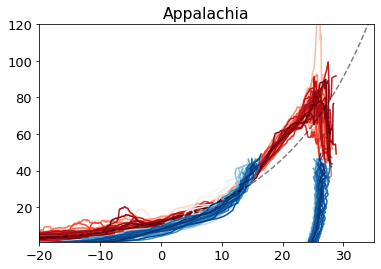

In [17]:
fig = plt.figure()
ax = fig.add_subplot(1, 1, 1)

re = 0

# PR scaling
cmap = matplotlib.cm.get_cmap('Reds')
smooth = 1 # years
prec_yy_all_smooth = np.apply_along_axis(lambda m: np.convolve(m, np.ones(smooth), mode='valid'), axis=0, arr=prec_yy_all)/smooth

for yy in range(prec_yy_all_smooth.shape[0]):
    rgba = cmap(yy/prec_yy_all_smooth.shape[0])
    plt.plot(bins_dT,prec_yy_all[yy,:,3,re], c=rgba)
    
# DT scaling
cmap = matplotlib.cm.get_cmap('Blues')
smooth = 1 # years
dT_yy_all_smooth = np.apply_along_axis(lambda m: np.convolve(m, np.ones(smooth), mode='valid'), axis=0, arr=dT_yy_all)/smooth

for yy in range(dT_yy_all_smooth.shape[0]):
    rgba = cmap(yy/dT_yy_all_smooth.shape[0])
    plt.plot(dT_yy_all_smooth[yy,:,0,re], bins_cent, c=rgba)
    
for yy in range(dT_yy_all_smooth.shape[0]):
    rgba = cmap(yy/dT_yy_all_smooth.shape[0])
    plt.plot(dT_yy_all_smooth[yy,:,-2,re], bins_cent, c=rgba)
    
plt.title(REGIONS_names[re])


y_CC_rate = np.array([12*(1 + 0.07)**bi for bi in bins_dT])
plt.plot(bins_dT,y_CC_rate, c='k', ls = '--', alpha=0.5)

plt.ylim((1,120))
plt.xlim((-20,35))

# ax.set_yscale('log')

### Load preprocessed data for scaling map
The data comes from - papers/2021_Hist-Ext-PR-Changes/programs/Scaling_Changes/Scaling_Changes.ipynb

In [18]:
pr_annual_max = np.zeros((len(Years), Lon.shape[0], Lon.shape[1])); pr_annual_max[:] = np.nan
dT_annual_max = np.copy(pr_annual_max)
for yy in range(len(Years)):
    YYYY = Years[yy]
    file_act = SaveFolder+'pr_vs_dT/'+str(YYYY)+'_pr-vs-dT_gridcells.npz'
    if os.path.isfile(file_act):
        DATA = np.load(file_act)
        pr_annual_max[yy,:,:] = DATA['max_pr']
        dT_annual_max[yy,:,:] = DATA['max_dt']

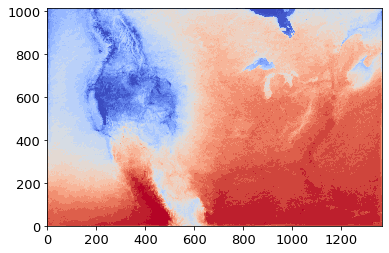

In [19]:
plt.contourf(np.mean(dT_annual_max, axis=0), levels=np.linspace(5,25,21), cmap='coolwarm', extend='both')

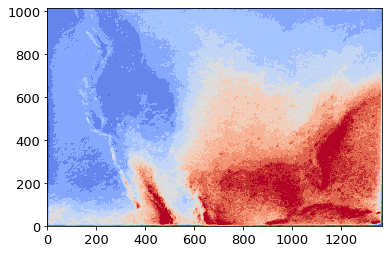

In [20]:
plt.contourf(np.mean(pr_annual_max, axis=0), levels=np.linspace(0,60,12), cmap='coolwarm', extend='both')

In [62]:
# fit exponential curves to data to estimate scaling rates
scaling_rate = np.zeros((Lon.shape[0], Lon.shape[1])); scaling_rate[:] = np.nan
scaling_rate_std = np.copy(scaling_rate)

from scipy.optimize import curve_fit
def func(x, li, sc):
    return li * (1+sc)**x

pool = 0
for la in tqdm(range(pool, Lon.shape[0]-pool-1, 1)):
    for lo in range(pool, Lon.shape[1]-pool-1, 1):
        peak_x = dT_annual_max[:,la-pool:la+pool+1,lo-pool:lo+pool+1].flatten()
        peak_y = pr_annual_max[:,la-pool:la+pool+1,lo-pool:lo+pool+1].flatten()
        try:
            popt, pcov = curve_fit(func, peak_x, peak_y, maxfev=800, p0 = [22,0.07])
            perr = np.sqrt(np.diag(pcov))
            scaling_rate[la,lo] = popt[1]*100
            scaling_rate_std[la,lo] = perr[1]*100
        except:
            continue
        

  0%|          | 1/1014 [00:00<06:50,  2.47it/s]/glade/u/apps/dav/opt/python/3.7.9/gnu/9.1.0/pkg-library/20201220/lib/python3.7/site-packages/ipykernel_launcher.py:7: RuntimeWarning: invalid value encountered in power
  import sys
  0%|          | 3/1014 [00:07<32:36,  1.94s/it]/glade/u/apps/dav/opt/python/3.7.9/gnu/9.1.0/pkg-library/20201220/lib/python3.7/site-packages/ipykernel_launcher.py:16: RuntimeWarning: invalid value encountered in sqrt
  app.launch_new_instance()
100%|██████████| 1014/1014 [09:48<00:00,  1.72it/s]


In [22]:
# # fit exponential curves to data to estimate scaling rates

# pool = 5

# scaling_rate = np.zeros((int(Lon.shape[0]/pool*2), int(Lon.shape[1]/pool*2))); scaling_rate[:] = np.nan
# scaling_rate_std = np.copy(scaling_rate)

# from scipy.optimize import curve_fit
# def func(x, li, sc):
#     return li * (1+sc)**x


# for la in tqdm(range(pool, int(Lon.shape[0]/(pool*2))+1, 1)):
#     for lo in range(pool, int(Lon.shape[1]/(pool*2))+1, 1):
#         peak_x = dT_annual_max[:,la-pool:la+pool+1,lo-pool:lo+pool+1].flatten()
#         peak_y = pr_annual_max[:,la-pool:la+pool+1,lo-pool:lo+pool+1].flatten()
# #         try:
#         popt, pcov = curve_fit(func, peak_x, peak_y, maxfev=800, p0 = [2,0.07])
#         perr = np.sqrt(np.diag(pcov))
#         scaling_rate[la,lo] = popt[1]*100
#         scaling_rate_std[la,lo] = perr[1]*100
# #         except:
# #             continue
        

In [23]:
scaling_colors = ['#045a8d','#5a96c6','#afdbef','#64ab5f','#eadf6d','#e9813d','#c93d35','#962722',
              '#7a0177','#c51b8a','#f768a1','#fa9fb5']#,'#fcc5c0']#,'#ea43f1']
lev_scaling = np.linspace(-1,15.5,len(scaling_colors))

dt_trend_colors = ['#67001f','#b2182b','#d6604d','#f4a582','#fddbc7','#f7f7f7','#d1e5f0','#92c5de','#4393c3','#2166ac','#053061']
lev_dt_trends = np.linspace(-1,1,12)

/glade/u/apps/dav/opt/python/3.7.9/gnu/9.1.0/pkg-library/20201220/lib/python3.7/site-packages/ipykernel_launcher.py:2: RuntimeWarning: invalid value encountered in less
  


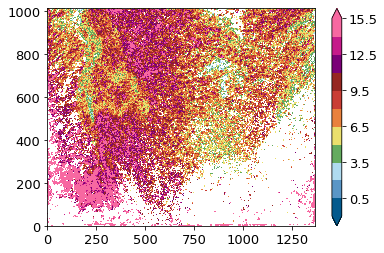

In [24]:
TEST = np.copy(scaling_rate)
TEST[TEST/scaling_rate_std < 2] = np.nan
CS3 = plt.contourf(TEST, levels=lev_scaling, colors=scaling_colors, extend='both')
plt.colorbar(CS3)

### Calculate trends in dT

In [25]:
# Calculate trends in mean precipitation
trend_mean_dT = np.zeros((Lon.shape[0],Lon.shape[1], 5)); trend_mean_dT[:] = np.nan
for la in tqdm(range(Lon.shape[0])):
    for lo in range(Lon.shape[1]):
        trend_mean_dT[la,lo,:] = stats.linregress(Years, dT_annual_max[:,la,lo])

 27%|██▋       | 276/1015 [03:00<08:03,  1.53it/s]


KeyboardInterrupt: 

### Calculate trends in annual extreme rainfall

In [26]:
trend_extreme_pr = np.zeros((Lon.shape[0],Lon.shape[1], 5)); trend_extreme_pr[:] = np.nan
for la in tqdm(range(Lon.shape[0])):
    for lo in range(Lon.shape[1]):
        trend_extreme_pr[la,lo,:] = stats.linregress(Years, pr_annual_max[:,la,lo])

  1%|▏         | 14/1015 [00:09<11:16,  1.48it/s]


KeyboardInterrupt: 

### Load the grid scale scaling estimates

In [97]:
# this data comes from - papers/2021_Hist-Ext-PR-Changes/programs/Scaling_Changes/Grid_scale_scaling/Grid_scale_scaling.py
gc_data_dir = '/glade/campaign/mmm/c3we/prein/CONUS404/data/CONUS404_processed_data/pr_vs_dT/gridcell_scaling/'
gc_data_files = np.sort(glob.glob(gc_data_dir+'*'))
for fi in tqdm(range(len(gc_data_files))):
    file_act = gc_data_dir + 'Gridcell-scaling_1980-2019_section_'+str(fi)+'.npz'
    DATA = np.load(file_act)
    dt_bin_cent = (DATA['bins_dT'][1:] + DATA['bins_dT'][:-1])/2
    pr_binned = DATA['pr_binned']
    
    # fit exponential curves to data to estimate scaling rates
    scaling_rate_gc = np.zeros((pr_binned.shape[2], pr_binned.shape[3])); scaling_rate_gc[:] = np.nan
    scaling_rate_gc_std = np.copy(scaling_rate_gc)

    from scipy.optimize import curve_fit
    def func(x, li, sc):
        return li * (1+sc)**x

    pool = 0
    for la in range(pool, pr_binned.shape[2]-pool, 1):
        for lo in range(pool, pr_binned.shape[3]-pool, 1):
            peak_x = dt_bin_cent
            peak_y = pr_binned[:,2,la-pool:la+pool+1,lo-pool:lo+pool+1].flatten()
            FIN = ~np.isnan(peak_y)
            try:
                popt, pcov = curve_fit(func, peak_x[FIN], peak_y[FIN], maxfev=800, p0 = [22,0.07])
                perr = np.sqrt(np.diag(pcov))
                scaling_rate_gc[la,lo] = popt[1]*100
                scaling_rate_gc_std[la,lo] = perr[1]*100
            except:
                continue
    
    if fi == 0:
        gc_scaling = scaling_rate_gc
        gc_scaling_std = scaling_rate_gc_std
    else:
        gc_scaling = np.append(gc_scaling, scaling_rate_gc, axis = 1)
        gc_scaling_std = np.append(gc_scaling_std, scaling_rate_gc_std, axis = 1)

 28%|██▊       | 11/39 [03:00<07:27, 16.00s/it]/glade/u/apps/dav/opt/python/3.7.9/gnu/9.1.0/pkg-library/20201220/lib/python3.7/site-packages/scipy/optimize/minpack.py:829: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)
100%|██████████| 39/39 [10:10<00:00, 15.66s/it]


11

work on NorthAtlantic.shp
work on Southeast.shp
work on Prairie.shp
work on Southwest.shp


/glade/u/apps/dav/opt/python/3.7.9/gnu/9.1.0/pkg-library/20201220/lib/python3.7/site-packages/ipykernel_launcher.py:21: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
/glade/u/apps/dav/opt/python/3.7.9/gnu/9.1.0/pkg-library/20201220/lib/python3.7/site-packages/ipykernel_launcher.py:21: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
/glade/u/apps/dav/opt/python/3.7.9/gnu/9.1.0/pkg-library/20201220/lib/python3.7/site-packages/ipykernel_

        Plot map to: PR-scaling-rates.jpg


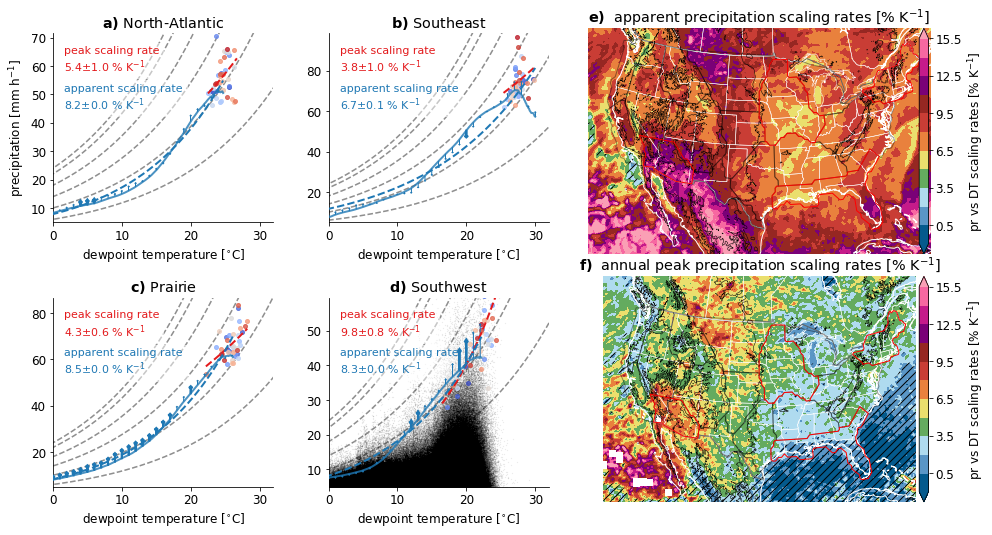

In [119]:
fig = plt.figure(figsize=(13,7))
rgsLableABC=list(string.ascii_lowercase)
plt.rcParams.update({'font.size': 12})
gs1 = gridspec.GridSpec(2,2)
gs1.update(left=0.05, right=0.58,
           bottom=0.08, top=0.98,
           wspace=0.25, hspace=0.40)

se=0
key_regions = [7,13,12,14]

XX = [0,1,0,1]
YY = [0,0,1,1]
for re in range(len(key_regions)):
    ax = plt.subplot(gs1[YY[re],XX[re]])
    
    print('work on '+REGIONS[key_regions[re]])
    
    # ===============================================
    #### SCALING ANALYSIS
    ax = plt.subplot(gs1[YY[re],XX[re]])

    pr_scaling_mean = np.mean(prec_yy_all[:,:,pr_perc.index(perc_pr),key_regions[re]], axis=0)
    plt.plot(bins_dT, pr_scaling_mean, c='#1f78b4', alpha=0.8, lw=2, zorder = 10)
    # add arrows for significant changes
    for bi in range(len(bins_dT))[::10]:
        dy = trend_pr[bi,0,key_regions[re]]*40
        if trend_pr[bi,3,key_regions[re]] <= 0.1:
            plt.arrow(x=bins_dT[bi], y=pr_scaling_mean[bi], dx=0, dy=dy, linewidth=2, facecolor='#1f78b4', edgecolor='#1f78b4', zorder = 10, head_width = 0.5) 
        else:
            plt.arrow(x=bins_dT[bi], y=pr_scaling_mean[bi], dx=0, dy=dy, linewidth=0.5, facecolor='#1f78b4', edgecolor='#1f78b4', zorder = 10, head_width = 0.3) 

#     # plot interpolated dT trends
#     trend_dT_high_mean = np.nanmean(dT_yy_interp[:,:,re], axis=0)
#     # plt.plot(trend_dT_high_mean, pr_bins_int, c='g', alpha=1)
#     for bi in range(len(pr_bins_int))[::2]:
#         dy = dT_yy_trend[bi,0,re]* 40
#         if dT_yy_trend[bi,3,re] <= 0.1:
#             plt.arrow(x=trend_dT_high_mean[bi], y=pr_bins_int[bi], dx=dy, dy=0, width=.3, facecolor='#1f78b4', edgecolor='none') 
#         else:
#             plt.arrow(x=trend_dT_high_mean[bi], y=pr_bins_int[bi], dx=dy, dy=0, width=.15, facecolor='#1f78b4', edgecolor='none') 


#     dT_scaling_mean = np.mean(dT_yy_all[:, :, dT_perc.index(perc_dT),key_regions[re]], axis=0)
#     plt.plot(dT_scaling_mean, bins_cent, c='#e31a1c', alpha=0.5)
#     # add arrows for significant changes
#     for bi in range(len(bins_cent))[::3]:
#         dx = trend_dT[bi,0,key_regions[re]]*40
#         if trend_dT[bi,3,key_regions[re]] <= 0.1:
#             plt.arrow(x=dT_scaling_mean[bi], y=bins_cent[bi], dx=dx, dy=0, linewidth=3, facecolor='#e31a1c', edgecolor='#e31a1c', head_width = 0.7, head_length=0.4) 
#         else:
#             plt.arrow(x=dT_scaling_mean[bi], y=bins_cent[bi], dx=dx, dy=0, linewidth=1, facecolor='#e31a1c', edgecolor='#e31a1c', head_width = 0.4, head_length=0.4) 

#     dT_scaling_mean = np.mean(dT_yy_all[:, :, dT_perc.index(perc_dT_high),key_regions[re]], axis=0)
#     plt.plot(dT_scaling_mean, bins_cent, c='#e31a1c', alpha=0.5)
#     # add arrows for significant changes
#     for bi in range(len(bins_cent))[::3]:
#         dx = trend_dT_high[bi,0,key_regions[re]]*40
#         if trend_dT_high[bi,3,key_regions[re]] <= 0.1:
#             plt.arrow(x=dT_scaling_mean[bi], y=bins_cent[bi], dx=dx, dy=0, linewidth=3, facecolor='#e31a1c', edgecolor='#e31a1c', head_width = 0.7, head_length=0.4) 
#         else:
#             plt.arrow(x=dT_scaling_mean[bi], y=bins_cent[bi], dx=dx, dy=0, linewidth=1, facecolor='#e31a1c', edgecolor='#e31a1c', head_width = 0.4, head_length=0.4) 


    # plot location of peak value
    cmap = matplotlib.cm.get_cmap('coolwarm')

    peak_x = np.zeros((prec_yy_all.shape[0])); peak_x[:] = np.nan
    peak_y = np.copy(peak_x)
    for yy in range(prec_yy_all.shape[0]):
        iMax = np.nanargmax(prec_yy_all[yy,:,pr_perc.index(perc_pr),key_regions[re]])
        rgba = cmap(yy/prec_yy_all.shape[0])
        peak_x[yy] = bins_dT[iMax]
        peak_y[yy] = prec_yy_all[yy,iMax,pr_perc.index(perc_pr),key_regions[re]]
        plt.plot(bins_dT[iMax],prec_yy_all[yy,iMax,pr_perc.index(perc_pr),key_regions[re]], color=rgba, marker = 'o', markersize=4, alpha = 0.8)
    
    
    # get peak scaling rate                 
    popt, pcov = curve_fit(func, peak_x, peak_y)
    y_CC_rate = np.array([popt[0]*(1 + popt[1])**bi for bi in np.sort(peak_x)])
    plt.plot(np.sort(peak_x),y_CC_rate, c='#e31a1c', ls = '--', alpha=1, zorder = 10, lw=2)
    perr = np.sqrt(np.diag(pcov))
    t = plt.text(0.05,0.8,'peak scaling rate\n'+str(np.round(popt[1]*100, 1))+\
             '$\pm$'+str(np.round(perr[1]/2*100,1))+' % K$^{-1}$', transform=ax.transAxes, c='#e31a1c', fontsize=11)
    t.set_bbox(dict(facecolor='white', alpha=0.5, edgecolor='white'))

    for li in [6,10,14,18,22,24]:
        y_CC_rate = np.array([li*(1 + 0.07)**bi for bi in bins_dT])
        plt.plot(bins_dT,y_CC_rate, c='k', ls = '--', alpha=0.25, zorder = 1)
        
    
    # get apparent scaling rate  
    FIN = ~np.isnan(pr_scaling_mean)
    peak_x = bins_dT[FIN]
    peak_y = pr_scaling_mean[FIN]
    
    popt, pcov = curve_fit(func, peak_x, peak_y)
    y_CC_rate = np.array([popt[0]*(1 + popt[1])**bi for bi in np.sort(peak_x)])
    plt.plot(np.sort(peak_x),y_CC_rate, c='#1f78b4', ls = '--', alpha=1, zorder = 10, lw=2)
    perr = np.sqrt(np.diag(pcov))
    t = plt.text(0.05,0.6,'apparent scaling rate\n'+str(np.round(popt[1]*100, 1))+\
             '$\pm$'+str(np.round(perr[1]/2*100,1))+' % K$^{-1}$', transform=ax.transAxes, c='#1f78b4', fontsize=11)
    t.set_bbox(dict(facecolor='white', alpha=0.5, edgecolor='white'))

    for li in [6,10,14,18,22,24]:
        y_CC_rate = np.array([li*(1 + 0.07)**bi for bi in bins_dT])
        plt.plot(bins_dT,y_CC_rate, c='k', ls = '--', alpha=0.25, zorder = 1)

        
        
    if REGIONS_names[key_regions[re]] == 'Southwest':
        # add scatter plot in the background
        plt.scatter(dT_yy_re_wet[::1], prec_yy_re_wet[::1], color='k', alpha = 0.1, s=0.1)

    plt.title(r"$\bf{" + rgsLableABC[re] + ")}$ "+REGIONS_names[key_regions[re]])
    plt.ylim((5,np.nanmax(pr_scaling_mean)*1.4))
    plt.xlim((0,32))
    
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    if re == 0:
        ax.set_ylabel('precipitation [mm h$^{-1}$]')
    
    ax.set_xlabel('dewpoint temperature [$^{\circ}$C]')
    
    
# ====================
# Add map of scaling rates

ncfile = Dataset(GEO_EM_D1)
HGT_M = getvar(ncfile, "HGT")
cart_proj = get_cartopy(HGT_M)
ncid.close()
from matplotlib import colors as c

CB = 50 # grid cells removed from boundary

gs2 = gridspec.GridSpec(2,1)
gs2.update(left=0.62, right=0.99,
           bottom=0.05, top=0.99,
           wspace=0.1, hspace=0.1)



# PLOT SEASONAL SCALING REATE
scalrate_smooth = scipy.ndimage.gaussian_filter(gc_scaling,4)
scalrate_std_smooth = scipy.ndimage.gaussian_filter(gc_scaling_std,4)
signal_to_noise = scalrate_smooth/scalrate_std_smooth

ax = plt.subplot(gs2[0,0], projection=cart_proj)
pos1 = ax.get_position()
cMap = c.ListedColormap(scaling_colors)
cs = plt.pcolormesh(Lon[CB:-CB,CB:-CB], Lat[CB:-CB,CB:-CB], scalrate_smooth[CB:-CB,CB:-CB], cmap=cMap, 
                    norm = mpl.colors.BoundaryNorm(lev_scaling, ncolors=len(lev_scaling)-1, clip=False),
                    transform=ccrs.PlateCarree())
# cs = plt.contourf(Lon[CB:-CB,CB:-CB], Lat[CB:-CB,CB:-CB], dry_hour_freq_rel[CB:-CB,CB:-CB], levels = np.linspace(80,100,21), extend='both', cmap='coolwarm', transform=ccrs.PlateCarree())
plt.contour(Lon[CB:-CB,CB:-CB], Lat[CB:-CB,CB:-CB], Height4[CB:-CB,CB:-CB], levels = (500, 2000), 
            colors='k', linewidths=0.5, transform=ccrs.PlateCarree(), transform_first=True)
plt.contourf(Lon[CB:-CB,CB:-CB-1], Lat[CB:-CB,CB:-CB-1], signal_to_noise[CB:-CB,CB:-CB], 
             levels=[-10,1, 2], hatches=['///', None], alpha=0, transform=ccrs.PlateCarree(), transform_first=True)

ax.coastlines(color='w')
ax.add_feature(cf.BORDERS, edgecolor='#636363')
ax.add_feature(cf.STATES, lw=0.5, edgecolor='w')
plt.axis('off')

# Plot bukofsky retions in addition
for re in range(len(REGIONS)):
    data = gpd.read_file('/glade/u/home/prein/papers/2021_Hist-Ext-PR-Changes/shapefiles/Bukovski-Regions/'+REGIONS[re])
    Coordinates = data['geometry']
    for sf in range(len(data)):
        TEST = np.array(Coordinates[sf].exterior.coords.xy)
        TEST=TEST.T
        if REGIONS[re] in np.array(REGIONS)[key_regions]:
            plt.plot(TEST[:,0],TEST[:,1], lw=1, c='r', transform=ccrs.PlateCarree(), alpha=1, zorder=10)
        else:
            plt.plot(TEST[:,0],TEST[:,1], lw=1, c='k', transform=ccrs.PlateCarree(), alpha=0.4)

plt.title(r"$\bf{" + rgsLableABC[4] + ")}$ "+' apparent precipitation scaling rates [% K$^{-1}$]')

CbarAx = axes([pos1.x1+0.05, pos1.y0, 0.01, pos1.height])
cb = colorbar(cs, cax = CbarAx, orientation='vertical', extend='both')#, ticks=np.linspace(0,0.0015,41))
# cb.ax.set_xticklabels(LEVS,rotation=90)
cb.set_label('pr vs DT scaling rates [% K$^{-1}$]', fontsize=12) 




# PLOT ANNUAL PEAK PRECIPITATION RATES
scalrate_smooth = scipy.ndimage.gaussian_filter(scaling_rate,4)
scalrate_std_smooth = scipy.ndimage.gaussian_filter(scaling_rate_std,4)
signal_to_noise = scalrate_smooth/scalrate_std_smooth

ax = plt.subplot(gs2[1,0], projection=cart_proj)
pos1 = ax.get_position()
cMap = c.ListedColormap(scaling_colors)
cs = plt.pcolormesh(Lon[CB:-CB,CB:-CB], Lat[CB:-CB,CB:-CB], scalrate_smooth[CB:-CB,CB:-CB], cmap=cMap, 
                    norm = mpl.colors.BoundaryNorm(lev_scaling, ncolors=len(lev_scaling)-1, clip=False),
                    transform=ccrs.PlateCarree())
# cs = plt.contourf(Lon[CB:-CB,CB:-CB], Lat[CB:-CB,CB:-CB], dry_hour_freq_rel[CB:-CB,CB:-CB], levels = np.linspace(80,100,21), extend='both', cmap='coolwarm', transform=ccrs.PlateCarree())
plt.contour(Lon[CB:-CB,CB:-CB], Lat[CB:-CB,CB:-CB], Height4[CB:-CB,CB:-CB], levels = (500, 2000), 
            colors='k', linewidths=0.5, transform=ccrs.PlateCarree(), transform_first=True)
plt.contourf(Lon[CB:-CB,CB:-CB], Lat[CB:-CB,CB:-CB], signal_to_noise[CB:-CB,CB:-CB], 
             levels=[-10,1, 2], hatches=['///', None], alpha=0, transform=ccrs.PlateCarree(), transform_first=True)

ax.coastlines(color='w')
ax.add_feature(cf.BORDERS, edgecolor='#636363')
ax.add_feature(cf.STATES, lw=0.5, edgecolor='w')
plt.axis('off')

# Plot bukofsky retions in addition
for re in range(len(REGIONS)):
    data = gpd.read_file('/glade/u/home/prein/papers/2021_Hist-Ext-PR-Changes/shapefiles/Bukovski-Regions/'+REGIONS[re])
    Coordinates = data['geometry']
    for sf in range(len(data)):
        TEST = np.array(Coordinates[sf].exterior.coords.xy)
        TEST=TEST.T
        if REGIONS[re] in np.array(REGIONS)[key_regions]:
            plt.plot(TEST[:,0],TEST[:,1], lw=1, c='r', transform=ccrs.PlateCarree(), alpha=1, zorder=10)
        else:
            plt.plot(TEST[:,0],TEST[:,1], lw=1, c='k', transform=ccrs.PlateCarree(), alpha=0.4)

plt.title(r"$\bf{" + rgsLableABC[5] + ")}$ "+' annual peak precipitation scaling rates [% K$^{-1}$]')

CbarAx = axes([pos1.x1+0.05, pos1.y0, 0.01, pos1.height])
cb = colorbar(cs, cax = CbarAx, orientation='vertical', extend='both')#, ticks=np.linspace(0,0.0015,41))
# cb.ax.set_xticklabels(LEVS,rotation=90)
cb.set_label('pr vs DT scaling rates [% K$^{-1}$]', fontsize=12) 

sPlotFile=''
sPlotName= 'PR-scaling-rates.jpg'
if os.path.isdir(sPlotFile) != 1:
    subprocess.call(["mkdir","-p",sPlotFile])
print( '        Plot map to: '+sPlotFile+sPlotName)
fig.savefig(sPlotFile+sPlotName, bbox_inches='tight', dpi=700)

In [117]:
signal_to_noise[CB:-CB,CB:-CB].shape

(915, 1266)

In [116]:
Lat[CB:-CB,CB:-CB].shape

(915, 1267)

In [ ]:
fig = plt.figure(figsize=(7.5,16))
rgsLableABC=list(string.ascii_lowercase)
plt.rcParams.update({'font.size': 13})
gs1 = gridspec.GridSpec(3,2)
gs1.update(left=0.05, right=0.98,
           bottom=0.4, top=0.98,
           wspace=0.30, hspace=0.40)

se=0
key_regions = [7,13,14]

for re in range(len(key_regions)):
    ax = plt.subplot(gs1[re,0])
    
    print('work on '+REGIONS[key_regions[re]])
    Contribution = np.median(pr_frac_contributions[:,0,:,key_regions[re]]*bins_width[:,None]/np.sum(pr_frac_contributions[:,0,:,key_regions[re]]*bins_width[:,None], axis=0), axis=1)
    cont_spread = np.percentile(pr_frac_contributions[:,0,:,key_regions[re]]*bins_width[:,None]/np.sum(pr_frac_contributions[:,0,:,key_regions[re]]*bins_width[:,None], axis=0), (25,75),  axis=1)
#     cont_spread = cont_spread*bins_width[None,:]/np.sum(cont_spread*bins_width[None,:], axis=1)[:,None]
    plt.plot(bins_cent, Contribution, c='k', label = '1980-1999')
    plt.fill_between(bins_cent, cont_spread[0,:], y2=cont_spread[1,:], color='k', alpha=0.2)

    Contribution1 = np.median(pr_frac_contributions[:,1,:,key_regions[re]]*bins_width[:,None]/np.sum(pr_frac_contributions[:,1,:,key_regions[re]]*bins_width[:,None], axis=0), axis=1)
    cont_spread1 = np.percentile(pr_frac_contributions[:,1,:,key_regions[re]]*bins_width[:,None]/np.sum(pr_frac_contributions[:,1,:,key_regions[re]]*bins_width[:,None], axis=0), (25,75),  axis=1)
    # cont_spread1 = cont_spread1*bins_width/np.sum(cont_spread1*bins_width, axis=1)[:,None]
    plt.plot(bins_cent, Contribution1, c='r', label = '2000-2020')
    plt.fill_between(bins_cent, cont_spread1[0,:], y2=cont_spread1[1,:], color='r', alpha=0.2)
    
    diff_all = (pr_frac_contributions[:,1,:,key_regions[re]]*bins_width[:,None]/np.sum(pr_frac_contributions[:,1,:,key_regions[re]]*bins_width[:,None], axis=0))-\
            (pr_frac_contributions[:,0,:,key_regions[re]]*bins_width[:,None]/np.sum(pr_frac_contributions[:,0,:,key_regions[re]]*bins_width[:,None], axis=0))
    plt.plot(bins_cent, np.median(diff_all, axis=1), c='b', label = 'difference')
    
    plt.fill_between(bins_cent, np.percentile(diff_all, 75, axis=1), y2=np.percentile(diff_all, 25, axis=1), color='b', alpha=0.2)
    ax.set_xscale('log')

    plt.axhline(y=0, color='k', linestyle='-', lw=0.75)
    if re == 0:
        ax.set_ylabel('fractional contribution []')
    ax.set_xlabel('precipitation [mm h$^{-1}$]')
        
    if re == 1:
        plt.legend()
    
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)

    plt.xlim((0.15,160))
#     plt.ylim((-12,8))
    
    plt.title(r"$\bf{" + rgsLableABC[re*2] + ")}$ "+REGIONS_names[key_regions[re]])
    
    # ===============================================
    #### SCALING ANALYSIS
    ax = plt.subplot(gs1[re,1])

    pr_scaling_mean = np.mean(prec_yy_all[:,:,pr_perc.index(perc_pr),key_regions[re]], axis=0)
    plt.plot(bins_dT, pr_scaling_mean, c='#1f78b4', alpha=0.8, lw=2, zorder = 10)
    # add arrows for significant changes
    for bi in range(len(bins_dT))[::10]:
        dy = trend_pr[bi,0,key_regions[re]]*40
        if trend_pr[bi,3,key_regions[re]] <= 0.1:
            plt.arrow(x=bins_dT[bi], y=pr_scaling_mean[bi], dx=0, dy=dy, linewidth=2, facecolor='#1f78b4', edgecolor='#1f78b4', zorder = 10, head_width = 0.5) 
        else:
            plt.arrow(x=bins_dT[bi], y=pr_scaling_mean[bi], dx=0, dy=dy, linewidth=0.5, facecolor='#1f78b4', edgecolor='#1f78b4', zorder = 10, head_width = 0.3) 

#     # plot interpolated dT trends
#     trend_dT_high_mean = np.nanmean(dT_yy_interp[:,:,re], axis=0)
#     # plt.plot(trend_dT_high_mean, pr_bins_int, c='g', alpha=1)
#     for bi in range(len(pr_bins_int))[::2]:
#         dy = dT_yy_trend[bi,0,re]* 40
#         if dT_yy_trend[bi,3,re] <= 0.1:
#             plt.arrow(x=trend_dT_high_mean[bi], y=pr_bins_int[bi], dx=dy, dy=0, width=.3, facecolor='#1f78b4', edgecolor='none') 
#         else:
#             plt.arrow(x=trend_dT_high_mean[bi], y=pr_bins_int[bi], dx=dy, dy=0, width=.15, facecolor='#1f78b4', edgecolor='none') 


#     dT_scaling_mean = np.mean(dT_yy_all[:, :, dT_perc.index(perc_dT),key_regions[re]], axis=0)
#     plt.plot(dT_scaling_mean, bins_cent, c='#e31a1c', alpha=0.5)
#     # add arrows for significant changes
#     for bi in range(len(bins_cent))[::3]:
#         dx = trend_dT[bi,0,key_regions[re]]*40
#         if trend_dT[bi,3,key_regions[re]] <= 0.1:
#             plt.arrow(x=dT_scaling_mean[bi], y=bins_cent[bi], dx=dx, dy=0, linewidth=3, facecolor='#e31a1c', edgecolor='#e31a1c', head_width = 0.7, head_length=0.4) 
#         else:
#             plt.arrow(x=dT_scaling_mean[bi], y=bins_cent[bi], dx=dx, dy=0, linewidth=1, facecolor='#e31a1c', edgecolor='#e31a1c', head_width = 0.4, head_length=0.4) 

#     dT_scaling_mean = np.mean(dT_yy_all[:, :, dT_perc.index(perc_dT_high),key_regions[re]], axis=0)
#     plt.plot(dT_scaling_mean, bins_cent, c='#e31a1c', alpha=0.5)
#     # add arrows for significant changes
#     for bi in range(len(bins_cent))[::3]:
#         dx = trend_dT_high[bi,0,key_regions[re]]*40
#         if trend_dT_high[bi,3,key_regions[re]] <= 0.1:
#             plt.arrow(x=dT_scaling_mean[bi], y=bins_cent[bi], dx=dx, dy=0, linewidth=3, facecolor='#e31a1c', edgecolor='#e31a1c', head_width = 0.7, head_length=0.4) 
#         else:
#             plt.arrow(x=dT_scaling_mean[bi], y=bins_cent[bi], dx=dx, dy=0, linewidth=1, facecolor='#e31a1c', edgecolor='#e31a1c', head_width = 0.4, head_length=0.4) 


    # plot location of peak value
    cmap = matplotlib.cm.get_cmap('coolwarm')

    peak_x = np.zeros((prec_yy_all.shape[0])); peak_x[:] = np.nan
    peak_y = np.copy(peak_x)
    for yy in range(prec_yy_all.shape[0]):
        iMax = np.nanargmax(prec_yy_all[yy,:,pr_perc.index(perc_pr),key_regions[re]])
        rgba = cmap(yy/prec_yy_all.shape[0])
        peak_x[yy] = bins_dT[iMax]
        peak_y[yy] = prec_yy_all[yy,iMax,pr_perc.index(perc_pr),key_regions[re]]
        plt.plot(bins_dT[iMax],prec_yy_all[yy,iMax,pr_perc.index(perc_pr),key_regions[re]], color=rgba, marker = 'o', markersize=4, alpha = 0.8)
    
    # get scaling rate                 
    popt, pcov = curve_fit(func, peak_x, peak_y)
    y_CC_rate = np.array([popt[0]*(1 + popt[1])**bi for bi in np.sort(peak_x)])
    plt.plot(np.sort(peak_x),y_CC_rate, c='#e31a1c', ls = '--', alpha=1, zorder = 10, lw=2)
    perr = np.sqrt(np.diag(pcov))
    plt.text(0.05,0.8,'scaling rate\n'+str(np.round(popt[1]*100, 1))+\
             '$\pm$'+str(np.round(perr[1]/2*100,1))+' % K$^{-1}$', transform=ax.transAxes, c='#e31a1c')

    for li in [6,10,14,18,22,24]:
        y_CC_rate = np.array([li*(1 + 0.07)**bi for bi in bins_dT])
        plt.plot(bins_dT,y_CC_rate, c='k', ls = '--', alpha=0.25, zorder = 1)
        
    if REGIONS_names[key_regions[re]] == 'Southwest':
        # add scatter plot in the background
        plt.scatter(dT_yy_re_wet[::1], prec_yy_re_wet[::1], color='k', alpha = 0.1, s=0.1)

    plt.title(r"$\bf{" + rgsLableABC[re*2+1] + ")}$ "+REGIONS_names[key_regions[re]])
    plt.ylim((5,np.nanmax(pr_scaling_mean)*1.4))
    plt.xlim((0,32))
    
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    if re == 0:
        ax.set_ylabel('precipitation [mm h$^{-1}$]')
    
    ax.set_xlabel('dewpoint temperature [$^{\circ}$C]')
    
    
# ====================
# Add map of scaling rates

scalrate_smooth = scipy.ndimage.gaussian_filter(scaling_rate,4)
scalrate_std_smooth = scipy.ndimage.gaussian_filter(scaling_rate_std,4)
signal_to_noise = scalrate_smooth/scalrate_std_smooth

ncfile = Dataset(GEO_EM_D1)
HGT_M = getvar(ncfile, "HGT")
cart_proj = get_cartopy(HGT_M)
ncid.close()
from matplotlib import colors as c

CB = 50 # grid cells removed from boundary

gs2 = gridspec.GridSpec(1,1)
gs2.update(left=0.01, right=0.99,
           bottom=0.05, top=0.32,
           wspace=0.1, hspace=0.3)

ax = plt.subplot(gs2[0,0], projection=cart_proj)
pos1 = ax.get_position()
cMap = c.ListedColormap(scaling_colors)
cs = plt.pcolormesh(Lon[CB:-CB,CB:-CB], Lat[CB:-CB,CB:-CB], scalrate_smooth[CB:-CB,CB:-CB], cmap=cMap, 
                    norm = mpl.colors.BoundaryNorm(lev_scaling, ncolors=len(lev_scaling)-1, clip=False),
                    transform=ccrs.PlateCarree())
# cs = plt.contourf(Lon[CB:-CB,CB:-CB], Lat[CB:-CB,CB:-CB], dry_hour_freq_rel[CB:-CB,CB:-CB], levels = np.linspace(80,100,21), extend='both', cmap='coolwarm', transform=ccrs.PlateCarree())
plt.contour(Lon[CB:-CB,CB:-CB], Lat[CB:-CB,CB:-CB], Height4[CB:-CB,CB:-CB], levels = (500, 2000), 
            colors='k', linewidths=0.5, transform=ccrs.PlateCarree(), transform_first=True)
plt.contourf(Lon[CB:-CB,CB:-CB], Lat[CB:-CB,CB:-CB], signal_to_noise[CB:-CB,CB:-CB], 
             levels=[-10,1, 2], hatches=['///', None], alpha=0, transform=ccrs.PlateCarree(), transform_first=True)

ax.coastlines(color='w')
ax.add_feature(cf.BORDERS, edgecolor='#636363')
ax.add_feature(cf.STATES, lw=0.5, edgecolor='w')
plt.axis('off')

# Plot bukofsky retions in addition
for re in range(len(REGIONS)):
    data = gpd.read_file('/glade/u/home/prein/papers/2021_Hist-Ext-PR-Changes/shapefiles/Bukovski-Regions/'+REGIONS[re])
    Coordinates = data['geometry']
    for sf in range(len(data)):
        TEST = np.array(Coordinates[sf].exterior.coords.xy)
        TEST=TEST.T
        if REGIONS[re] in np.array(REGIONS)[key_regions]:
            plt.plot(TEST[:,0],TEST[:,1], lw=1, c='r', transform=ccrs.PlateCarree(), alpha=1, zorder=10)
        else:
            plt.plot(TEST[:,0],TEST[:,1], lw=1, c='k', transform=ccrs.PlateCarree(), alpha=0.4)

plt.title(r"$\bf{" + rgsLableABC[6] + ")}$ "+' annual peak precipitation scaling rates [% K$^{-1}$]')

CbarAx = axes([pos1.x0, pos1.y0-0.025, pos1.width, 0.01])
cb = colorbar(cs, cax = CbarAx, orientation='horizontal', extend='both')#, ticks=np.linspace(0,0.0015,41))
# cb.ax.set_xticklabels(LEVS,rotation=90)
cb.set_label('pr vs DT scaling rates [% K$^{-1}$]', fontsize=12) 

sPlotFile=''
sPlotName= 'Changes-in-fractional-PR_and_scaling-rates.jpg'
if os.path.isdir(sPlotFile) != 1:
    subprocess.call(["mkdir","-p",sPlotFile])
print( '        Plot map to: '+sPlotFile+sPlotName)
fig.savefig(sPlotFile+sPlotName, bbox_inches='tight', dpi=700)

### Plot DT trends and scaling rates on map

In [ ]:
scalrate_smooth = scipy.ndimage.gaussian_filter(scaling_rate,4)
scalrate_std_smooth = scipy.ndimage.gaussian_filter(scaling_rate_std,4)
signal_to_noise = scalrate_smooth/scalrate_std_smooth

ncfile = Dataset(GEO_EM_D1)
HGT_M = getvar(ncfile, "HGT")
cart_proj = get_cartopy(HGT_M)
ncid.close()
from matplotlib import colors as c

CB = 50 # grid cells removed from boundary


fig = plt.figure(figsize=(10,5))
rgsLableABC=list(string.ascii_lowercase)
plt.rcParams.update({'font.size': 13})
gs1 = gridspec.GridSpec(1,2)
gs1.update(left=0.05, right=0.97,
           bottom=0.05, top=0.9,
           wspace=0.1, hspace=0.3)

# -------------------------
# dewpoint temperature trends
ax = plt.subplot(gs1[0,0], projection=cart_proj)

pos1 = ax.get_position()
cMap = c.ListedColormap(dt_trend_colors)
# cs = plt.pcolormesh(Lon[CB:-CB,CB:-CB], Lat[CB:-CB,CB:-CB], trend_mean_dT[CB:-CB,CB:-CB,0]*10, cmap=cMap, 
#                     norm = mpl.colors.BoundaryNorm(lev_dt_trends, ncolors=len(lev_dt_trends)-1, clip=False),
#                     transform=ccrs.PlateCarree())
cs = plt.contourf(Lon[CB:-CB,CB:-CB], Lat[CB:-CB,CB:-CB], trend_mean_dT[CB:-CB,CB:-CB,0]*10, colors=dt_trend_colors, 
                    levels = lev_dt_trends, extend = 'both', transform=ccrs.PlateCarree(), transform_first=True)
plt.contourf(Lon[CB:-CB,CB:-CB], Lat[CB:-CB,CB:-CB], signal_to_noise[CB:-CB,CB:-CB], levels=[-10,1, 2], 
                      hatches=['///', None], alpha=0, transform=ccrs.PlateCarree(), transform_first=True)

ax.coastlines(color='#636363')
ax.add_feature(cf.BORDERS, edgecolor='#636363')
ax.add_feature(cf.STATES, lw=0.5, edgecolor='#636363')
plt.axis('off')
plt.title(r"$\bf{" + rgsLableABC[0] + ")}$ "+' DT during annual pr events trends [K decade$^{-1}$]')

CbarAx = axes([pos1.x0, pos1.y0-0.025, pos1.width, 0.02])
cb = colorbar(cs, cax = CbarAx, orientation='horizontal', extend='both')#, ticks=np.linspace(0,0.0015,41))
# cb.ax.set_xticklabels(LEVS,rotation=90)
cb.set_label('dry hour frequency [%]', fontsize=12)   


# # -------------------------
# # scaling rates
# ax = plt.subplot(gs1[0,1], projection=cart_proj)
# pos1 = ax.get_position()
# cMap = c.ListedColormap(scaling_colors)
# cs = plt.pcolormesh(Lon[CB:-CB,CB:-CB], Lat[CB:-CB,CB:-CB], scalrate_smooth[CB:-CB,CB:-CB], cmap=cMap, 
#                     norm = mpl.colors.BoundaryNorm(lev_scaling, ncolors=len(lev_scaling)-1, clip=False),
#                     transform=ccrs.PlateCarree())
# # cs = plt.contourf(Lon[CB:-CB,CB:-CB], Lat[CB:-CB,CB:-CB], dry_hour_freq_rel[CB:-CB,CB:-CB], levels = np.linspace(80,100,21), extend='both', cmap='coolwarm', transform=ccrs.PlateCarree())
# plt.contour(Lon[CB:-CB,CB:-CB], Lat[CB:-CB,CB:-CB], Height4[CB:-CB,CB:-CB], levels = (500, 2000), 
#             colors='k', linewidths=0.5, transform=ccrs.PlateCarree(), transform_first=True)
# plt.contourf(Lon[CB:-CB,CB:-CB], Lat[CB:-CB,CB:-CB], signal_to_noise[CB:-CB,CB:-CB], 
#              levels=[-10,1, 2], hatches=['///', None], alpha=0, transform=ccrs.PlateCarree(), transform_first=True)

# ax.coastlines(color='w')
# ax.add_feature(cf.BORDERS, edgecolor='#636363')
# ax.add_feature(cf.STATES, lw=0.5, edgecolor='w')
# plt.axis('off')
# plt.title(r"$\bf{" + rgsLableABC[1] + ")}$ "+' annual peak precipitation\nscaling rates [% K$^{-1}$]')

# CbarAx = axes([pos1.x0, pos1.y0-0.025, pos1.width, 0.02])
# cb = colorbar(cs, cax = CbarAx, orientation='horizontal', extend='both')#, ticks=np.linspace(0,0.0015,41))
# # cb.ax.set_xticklabels(LEVS,rotation=90)
# cb.set_label('pr vs DT scaling rates [% K$^{-1}$]', fontsize=12) 

